In [11]:
import os, sys
import numpy as np
import pandas as pd

import torch

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [2]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)

In [3]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(2020))

max_sequence_length = 20
train = train.to_sequence(max_sequence_length=max_sequence_length)
test = test.to_sequence(max_sequence_length=max_sequence_length)

In [45]:
%run helpers.ipynb

### load appropriate models

In [24]:
pool_model = load_model('pooling')
lstm_model = load_model('entire')

## Use embeddings from **pooling** model to compute item similarities on **LSTM-based** model recommendations

In [25]:
best_cfs, _ = find_cfs(test, lstm_model, 7, no_users=500)

In [26]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_cfs:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        total_data.append(rec.proximity_loss)
    
cnt = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

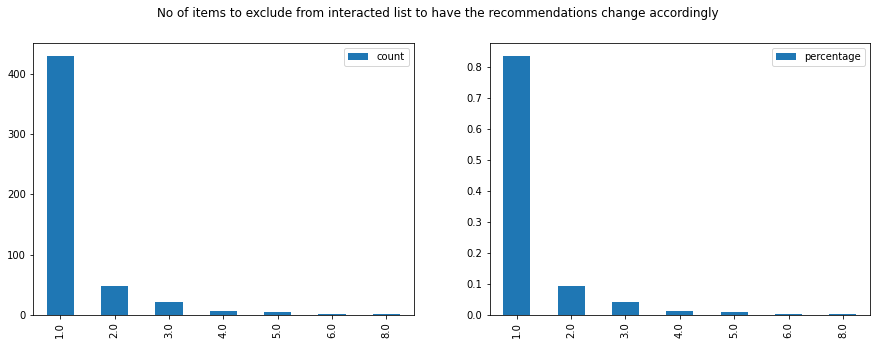

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [28]:
pooling_sims_matrix = gpu_embeddings_to_cosine_similarity_matrix(
    pool_model._net.item_embeddings(
        torch.arange(0, test.num_items, dtype=torch.int64)
    ))

In [32]:
cnt, non_solvable = rank_interactions_to_excluded_item_per_user(best_cfs, pooling_sims_matrix.detach().numpy())

Text(0.5, 0.98, 'Counting the worst similarity position of each discovered counterfactual')

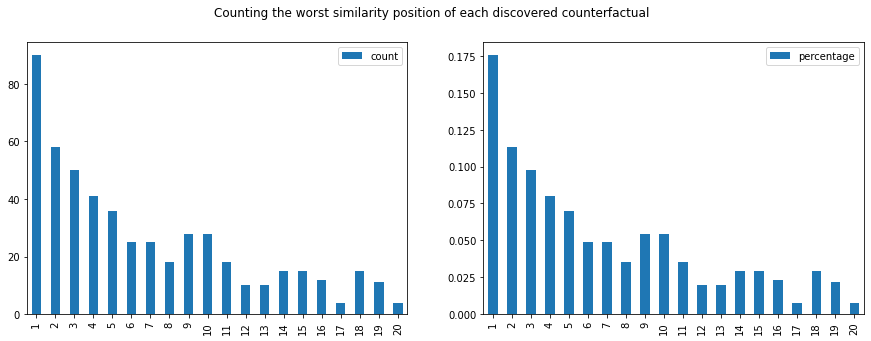

In [33]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('Counting the worst similarity position of each discovered counterfactual')

## Compute item similarities with **Jaccard** on implicit interactions on **Pooling-based** model recommendations

In [34]:
best_cfs, _ = find_cfs(test, pool_model, 7, no_users=500)

In [46]:
jaccard_similarities_matrix = compute_sim_matrix('jaccard')

In [36]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_cfs:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        total_data.append(rec.proximity_loss)
    
cnt = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

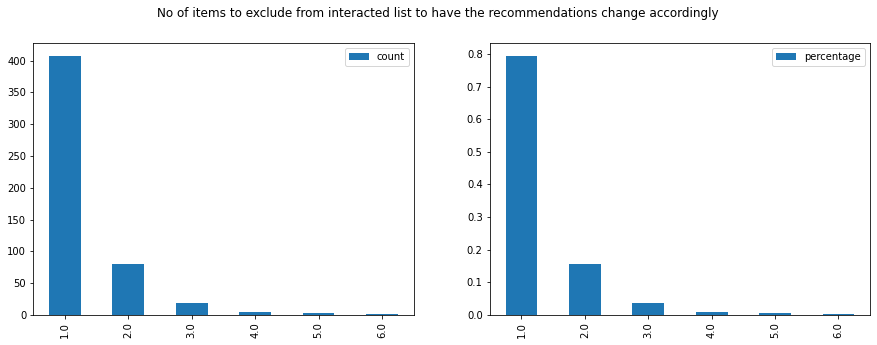

In [37]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [47]:
cnt, non_solvable = rank_interactions_to_excluded_item_per_user(best_cfs, jaccard_similarities_matrix)

Text(0.5, 0.98, 'Counting the worst similarity position of each discovered counterfactual')

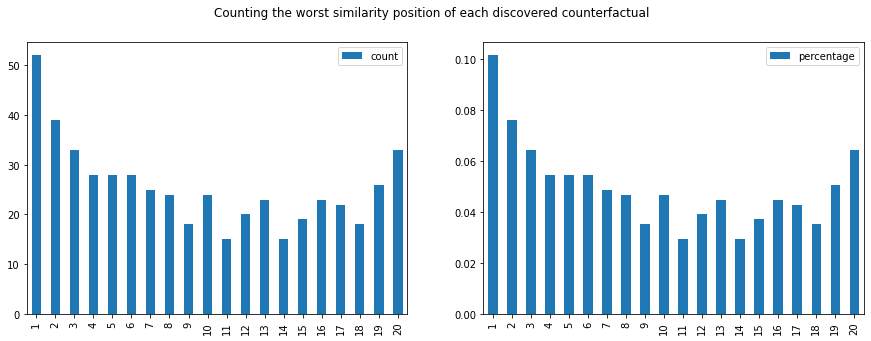

In [48]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('Counting the worst similarity position of each discovered counterfactual')